# Tracking a spiraling object using the extended / unscented Kalman filter





Consider an object moving in $\mathbb{R}^2$.
We assume that we observe a noisy version of its location at each time step.
We want to track the object and possibly forecast its future motion.
We now show how to do this using a simple nonlinear Gaussian SSM, combined with 
various extensions of the Kalman filter algorithm.

Let the hidden state represent
the position  of the object,
$z_t =\begin{pmatrix} u_t &  v_t  \end{pmatrix}$.
(We use $u$ and $v$ for the two coordinates,
to avoid confusion with the state and observation variables.)
We assume the following nonlinear dynamics:

\begin{align*}
z_t &= f(z_{t-1}) + q_t \\
f(\begin{pmatrix} u \\ v \end{pmatrix})
 &= \begin{pmatrix} u + 0.5 \sin(v) \\ v + \cos(u) \end{pmatrix}
\end{align*}

where $q_t \in \mathbb{R}^2$ is the process noise, which we assume is Gaussian,
so  $q_t \sim N(0,Q)$.


At each discrete time point we
observe the location corrupted by  Gaussian noise.
Thus the observation model becomes

\begin{align*}
y_t &= h(z_t) + r_t \\
h(\begin{pmatrix} u \\ v \end{pmatrix}) &= \begin{pmatrix} u \\ v \end{pmatrix}
\end{align*}

where $r_t \sim N(0,R)$ is the observation noise.

We show how to perform approximate inference of the latent states in this nonlinear dynamical system model using an Extended Kalman Filter (EKF) or an Unscented Kalman Filter (UKF). These algorithms work by approximating the nonlinear model with a linear Gaussian model, with two different types of approximations. For more detail on these algorithms, see Murphy (2023) or Särkkä and Svensson (2023).

## References
- Murphy, Kevin P. Probabilistic machine learning: Advanced topics. MIT press, 2023.
- Särkkä, Simo, and Lennart Svensson. Bayesian filtering and smoothing. Vol. 17. Cambridge university press, 2023.




## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from dynamax.utils.plotting import  plot_uncertainty_ellipses
from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, NonlinearGaussianSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_filter as ekf
from dynamax.nonlinear_gaussian_ssm import unscented_kalman_filter as ukf


## Create the model

In [3]:

state_dim = 2
obs_dim = 2
f = lambda z: z + 0.4 * jnp.array([jnp.sin(z[1]), jnp.cos(z[0])])
h = lambda z: z

params = ParamsNLGSSM(
    initial_mean = jnp.array([1.5, 0.0]),
    initial_covariance = jnp.eye(state_dim),
    dynamics_function = f,
    dynamics_covariance = jnp.eye(state_dim) * 0.001,
    emission_function = h,
    emission_covariance = jnp.eye(obs_dim) * 0.05
)

nlgssm = NonlinearGaussianSSM(state_dim, obs_dim)


## Sample some data from the model

In [4]:
key = jr.PRNGKey(0)
states, emissions = nlgssm.sample(params, key, num_timesteps=100)

In [5]:
def plot_inference(states, 
                   emissions, 
                   estimates=None, 
                   est_type="", 
                   ax=None, 
                   title="", 
                   show_states=True):
    """
    Helper function to plot the states, emissions and (optionally) estimates.

    """
    if ax is None:
        fig, ax = plt.subplots()
    if show_states:
        ax.plot(*states.T, label="True States", lw=3)
    ax.plot(*emissions.T, ".", color='k',  ms=6, label="Observations")
    if estimates is not None:
        ax.plot(*estimates.T, color="r", linewidth=1.5, ls='-', label=f"{est_type} Estimate")
    ax.set_title(title)
    ax.legend(borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    ax.axis('equal')
    ax.set_xlabel(r"$u$")
    ax.set_ylabel(r"$v$")
    return ax

<Axes: title={'center': 'Noisy obervations from hidden trajectory'}, xlabel='$u$', ylabel='$v$'>

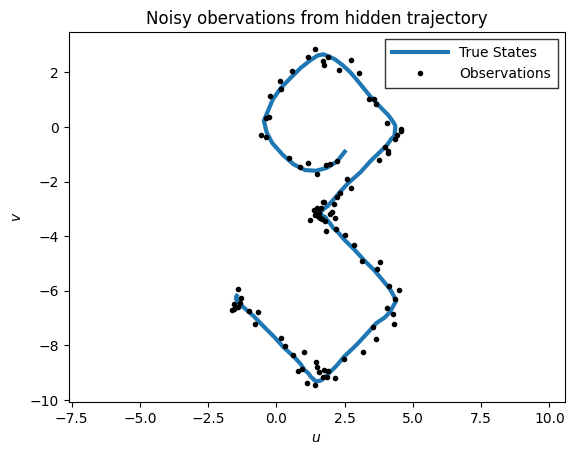

In [6]:
plot_inference(states, emissions, title="Noisy obervations from hidden trajectory")

## Extended Kalman filter

The extended Kalman filter (EKF) is an approximate inference algorithm for systems with nonlinear dynamics and/or emissions and Gaussian noise. It works by using a first-order Taylor approximation to the dynamics and/or emissions functions, and the n running a standard Kalman filter on the "linearized" model. The EKF tends to work well when the dynamics and emissions are well-approximated by their first-order Taylor function around the predictive means, and when the Jacobians of these functions are available. Dynamax uses automatic differentiation to compute these Jacobians.




In [7]:
ekf_params = params
ekf_post = ekf(ekf_params, emissions)
ekf_means, ekf_covs = ekf_post.filtered_means, ekf_post.filtered_covariances

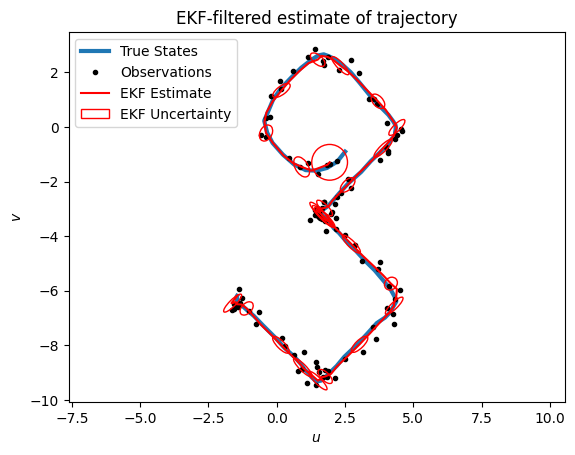

In [8]:
ax = plot_inference(states, emissions, ekf_means, "EKF", title="EKF-filtered estimate of trajectory")
# Add uncertainty ellipses to every fourth estimate
plot_uncertainty_ellipses(ekf_means[::4], ekf_covs[::4], ax, 
                          zorder=10, edgecolor='r', label="EKF Uncertainty")
plt.legend()

## Unscented Kalman Filter

The Unscented Kalman Filter (UKF) works by matching moments of a Gaussian approximation to the filtering and predictive distributions. Briefly, the UKF passes a grid of _sigma points_ through the dynamics and emissions functions, and then uses the weighted mean and covariance of the transformed points to form the Gaussian approximation. 


Should you use an EKF or a UKF for your problem? Särkkä (2023; pg. 160) says the following,
> ...the unscented transform is able to capture the higher order moments caused by the non-linear transform better than Taylor series-based approximations. However, as already pointed out in the previous section, although the mean estimate of the UKF is exact for polynomials up to order three, the covariance computation is only exact for polynomials up to first order. In the UKF, the dynamic and model functions are also not required to be formally differentiable nor do their Jacobian matrices need to be computed. The disadvantage over the EKF is that the UKF often re quires slightly more computational operations than the EKF.

Furthermore, as we demonstrate in the pendulum notebook nearby, the UKF is sensitive to the choice of hyperparameters that determine the sigma points, whereas the EKF is essentially hyperparameter-free.



In [9]:
hyperparams = UKFHyperParams() 
ukf_post = ukf(params, emissions, hyperparams)
ukf_means, ukf_covs = ukf_post.filtered_means, ukf_post.filtered_covariances

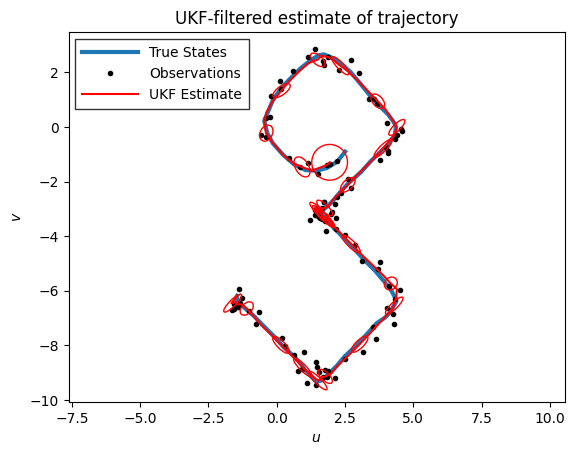

In [10]:
# Plot the UKF inferences and add uncertainty ellipses to every fourth estimate
ax = plot_inference(states, emissions, ekf_means, "UKF", title="UKF-filtered estimate of trajectory")
plot_uncertainty_ellipses(ukf_means[::4], ukf_covs[::4], 
                          ax=ax, zorder=10, edgecolor='r', label="UKF Uncertainty")

The EKF and UKF yield very similar estimates for this problem, but they're not exactly the same.

In [11]:
print(f"Max diff. between EKF & UKF means: {abs(ukf_means - ekf_means).max():.4f}")
print(f"Max diff. between EKF & UKF covs:  {abs(ukf_covs - ekf_covs).max():.4f}")

Max diff. between EKF & UKF means: 0.0151
Max diff. between EKF & UKF covs:  0.0002


## Marginal log likelihood

The extended and unscented Kalman filters also return an approximate marginal log likelihood,
\begin{align*}
p(y_{1:T}; \theta) 
&= \prod_{t=1}^T p(y_t \mid y_{1:t-1}; \theta) \\
&= \prod_{t=1}^T \int \mathrm{N}(y_t \mid h(z_t), R) \, p(z_t \mid y_{1:t-1}; \theta) \, \mathrm{d}z_t \\
&\approx \prod_{t=1}^T \int \mathrm{N}(y_t \mid h(z_t), R) \, \mathrm{N}(z_t \mid \mu_{t|t-1}, \Sigma_{t|t-1}) \, \mathrm{d}z_t
\end{align*}

where $\mu_{t|t-1}$ and $\Sigma_{t|t-1}$ are the predictive mean and covariance approximations, respectively. 

Finally, the EKF and UKF use different approximations of the integral in the last line &mdash; the EKF uses a Taylor approximation of the emission function and the UKF uses the mean and covariance of the transformed sigma points.

The marginal log likelihood is not exact for these nonlinear models, but it can still serve as a viable optimization target for parameter estimation. That is, you could maximize the approximate marginal log likelihood to estimate parameters of the model, $\hat{\theta}$.

In [12]:
print(f"EKF Marginal LL Estimate: {ekf_post.marginal_loglik:.3f}")
print(f"UKF Marginal LL Estimate: {ukf_post.marginal_loglik:.3f}")

EKF Marginal LL Estimate: -7.378
UKF Marginal LL Estimate: -7.052


## Conclusion

This notebook demonstrates the extended and unscented Kalman filters in Dynamax on a simple nonlinear dynamical system. The notebook shows how to infer the latent states and approximate the marginal log likelihood for parameter estimation. 